In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cookie-cats/cookie_cats.csv


# Part 1. Project Background

This project involves examining an AB test conducted on Cookie Cats, where the initial gate was shifted from level 30 to level 40. Our main focus will be to analyze how this change affected player retention.


# Load the AB-test data



In [2]:
import pandas as pd

df = pd.read_csv('/kaggle/input/cookie-cats/cookie_cats.csv')
df.head(3)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


The data is from 90,189 players that installed the game while the AB-test was running. The variables are:

1. userid - a unique number that identifies each player.

2. version - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).

3. sum_gamerounds - the number of game rounds played by the player during the first week after installation

4. retention_1 - did the player come back and play 1 day after installing?

5. retention_7 - did the player come back and play 7 days after installing?

When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

In [4]:
# Count the number of players in each group

df.groupby('version').count()

# When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40. 
# The number of players is roughly the same in the control and test group, nice!

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


<Axes: >

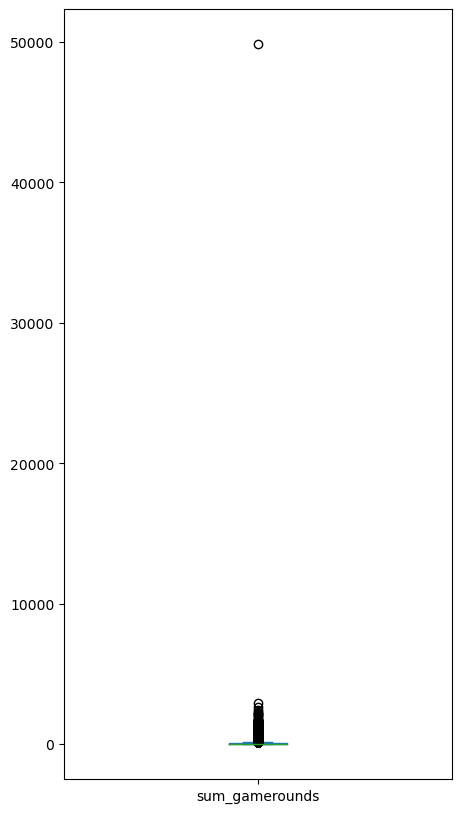

In [5]:
#  Analyzing Player Behavior 
# We will plot a boxplot to visualize the distribution of 'sum_gamerounds', 
# which would give us a rough idea of how many game rounds were played by a player during the first week after installing the game.

df['sum_gamerounds'].plot.box(figsize=(5,10))

# Clearly, there is an outlier. This player played about 50,000 game rounds during the first week! Due to this outlier, 
# this boxplot is extremely skewed and not very informative. 
# To learn about the behavior of the majority of the players, we will check the percentiles.

In [6]:
df['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

In [7]:
# Counting the number of players for each number of gamerounds 
plot_df = df.groupby('sum_gamerounds')['userid'].count()
plot_df

sum_gamerounds
0        3994
1        5538
2        4606
3        3958
4        3629
         ... 
2294        1
2438        1
2640        1
2961        1
49854       1
Name: userid, Length: 942, dtype: int64

# a. As we can see, 50% of players played fewer than 16 game rounds during the first week after installation, and 75% of players played fewer than 51 rounds.

# b. Nearly 4000 players did not even play a single round after installation. Possible reasons may include:

They downloaded a number of new games at the same time and were attracted by other games.

They opened the app but did not like the design/interface/music, so they quit even before playing the game.

They have not started playing the game yet.
......

# c. Another number worth attention is that more than 14,000 players played fewer than three rounds. For these players, the reasons for leaving may include:

They did not enjoy the game. (This is probably the most common reason).

The game turned out to be different from what they expected.

The game was too easy and they got bored of it.
......

It is important to understand why a large number of players quit the game at an early stage. Tactile Entertainment can try to collect player feedback, for example, through an in-app survey.

Text(0.5, 0, '# Game rounds')

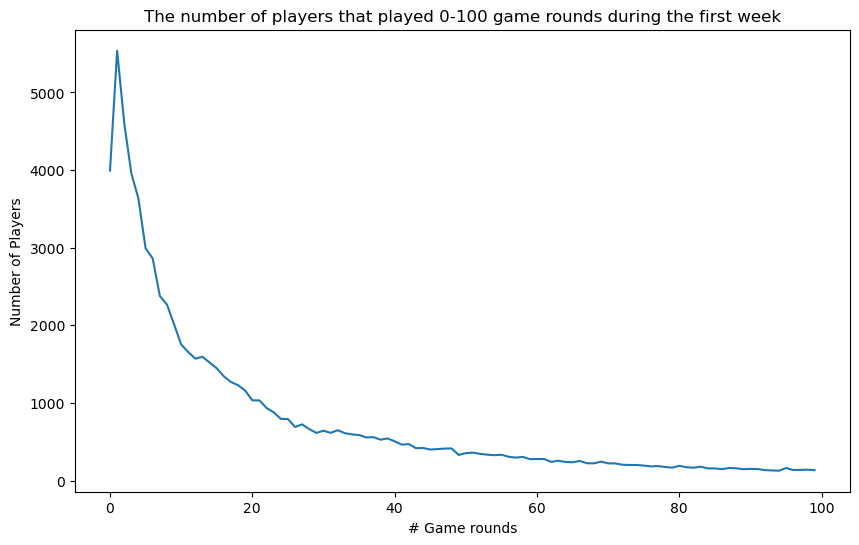

In [8]:
# Plot the distribution of players that played 0 to 100 game rounds during their first week playing the game.
%matplotlib inline

ax = plot_df[:100].plot(figsize=(10,6))
ax.set_title("The number of players that played 0-100 game rounds during the first week")
ax.set_ylabel("Number of Players")
ax.set_xlabel('# Game rounds')

Text(0.5, 0, '# Game rounds')

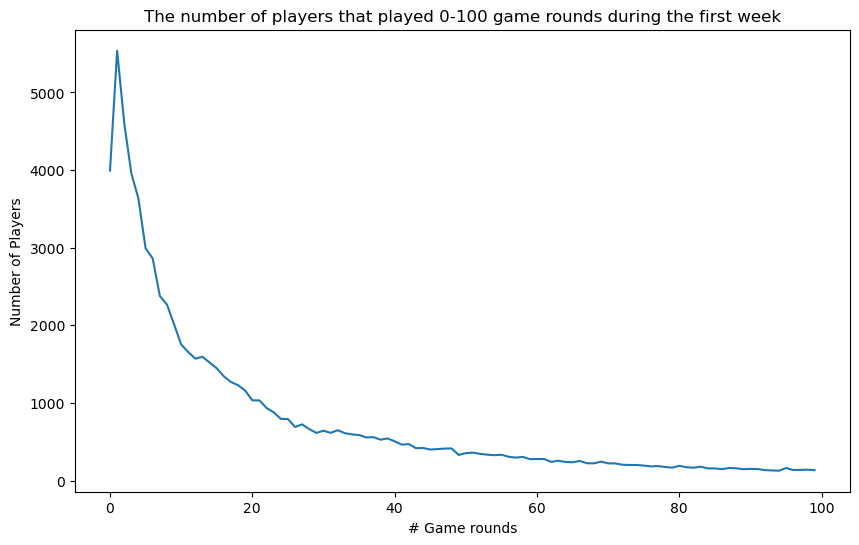

In [9]:
# Plot the distribution of players that played 0 to 100 game rounds during their first week playing the game.
%matplotlib inline

ax = plot_df[:100].plot(figsize=(10,6))
ax.set_title("The number of players that played 0-100 game rounds during the first week")
ax.set_ylabel("Number of Players")
ax.set_xlabel('# Game rounds')

# The distribution is highly skewed, with a long tail on the right. 
# A huge number of players played fewer than 20 rounds and left the game. For rounds greater than 60, the number of players stayed steady at about 300.

# Part 4. Comparing 1-day Retention

In the plot above we can see that some players install the game but then never play it, some players just play a couple of game rounds in their first week, and some get really hooked! What we want is for players to like the game and to get hooked.

A common metric in the video gaming industry for how fun and engaging a game is 1-day retention: the percentage of players that comes back and plays the game one day after they have installed it. The higher 1-day retention is, the easier it is to retain players and build a large player base.


In [10]:
# Overall 1-day retention

df['retention_1'].sum() / df['retention_1'].count() # When using .sum(), T/F will first be converted to 1/0.

# Equivalent to df['retention_1'].mean()
# Mean is calculated by summing the values and dividing by the total number of values.

# A little less than half of the players come back one day after installing the game. 
# Now that we have a benchmark, let's look at how 1-day retention differs between the two AB-groups.

0.4452095044850259

In [11]:
# 1-day retention for each AB-group
df.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

It appears that there was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control when it was at level 30 (44.8%). It's a small change, but even small changes in retention can have a large impact. But while we are certain of the difference in the data, how certain should we be that a gate at level 40 will be worse in the future?

There are a couple of ways we can get at the certainty of these retention numbers. Here we will use bootstrapping: We will repeatedly re-sample our dataset (with replacement) and calculate 1-day retention for those samples. The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.

# Bootstrapping: Should we be confident in the difference?


<Axes: ylabel='Density'>

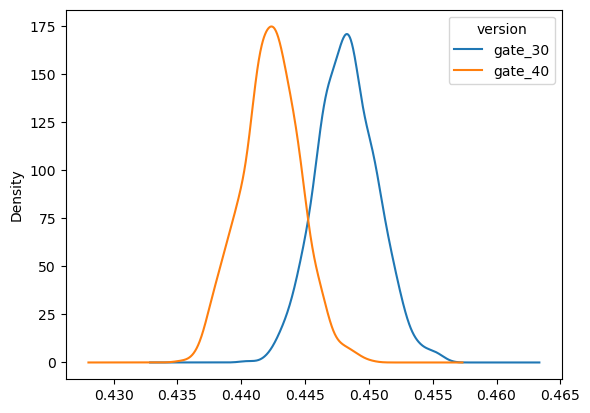

In [12]:
# Creating a list with bootstrapped means for each AB-group
boot_1d = []
for i in range(1000):
    boot_mean = df.sample(frac = 1,replace = True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot(kind='density')

# These two distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the two AB-groups.
# There seems to be some evidence of a difference, albeit small. Let's plot the % difference to have a closer look.

Probability that 1-day retention is greater when the gate is at level 30: 0.962


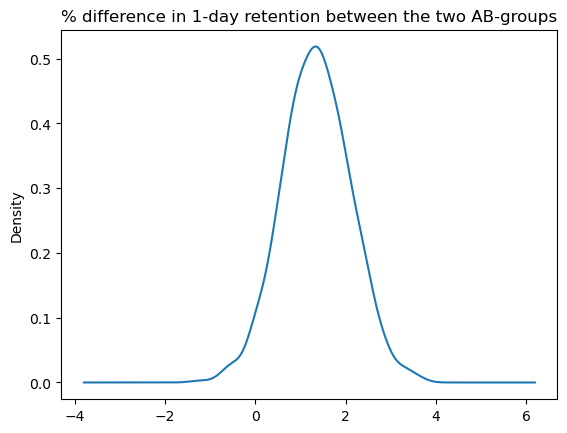

In [13]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = (boot_1d.gate_30 - boot_1d.gate_40)/boot_1d.gate_40*100

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot(kind='density')
ax.set_title('% difference in 1-day retention between the two AB-groups')

# Calculating the probability that 1-day retention is greater when the gate is at level 30
print('Probability that 1-day retention is greater when the gate is at level 30:',(boot_1d['diff'] > 0).mean())

# we can see that the most likely % difference is around 1% - 2%, and that 96% of the distribution is above 0%, in favor of a gate at level 30.

# Part 5. Comparing 7-day Retention

The bootstrap analysis tells us that there is a high probability that 1-day retention is better when the gate is at level 30. However, since players have only been playing the game for one day, it is likely that most players haven't reached level 30 yet. That is, many players won't have been affected by the gate, even if it's as early as level 30.

But after having played for a week, more players should have reached level 40, and therefore it makes sense to also look at 7-day retention.

In [14]:
df.groupby('version')['retention_7'].sum() / df.groupby('version')['retention_7'].count()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

Insights:

Like with 1-day retention, 7-day retention is slightly lower when the gate is at level 40 (18.2%) than when the gate is at level 30 (19.0%).

This difference is also larger than for 1-day retention, presumably because more players have had time to hit the first gate.

The overall 7-day retention is lower than the overall 1-day retention; fewer people play a game a week after installing than a day after installing.

But as before, let's use bootstrap analysis to figure out how certain we should be of the difference between the AB-groups.

Probability that 7-day retention is greater when the gate is at level 30: 0.992


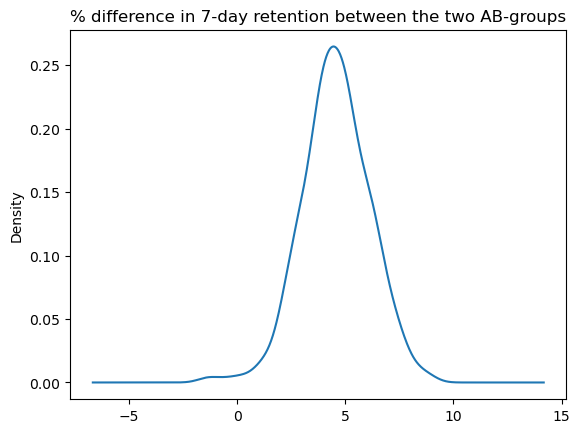

In [15]:
# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1,replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)

# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d.gate_30 - boot_7d.gate_40)/boot_7d.gate_40*100

# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot(kind='density')
ax.set_title('% difference in 7-day retention between the two AB-groups')

# Calculating the probability that 7-day retention is greater when the gate is at level 30
print('Probability that 7-day retention is greater when the gate is at level 30:',(boot_7d['diff'] > 0).mean())

# Part 6. Conclusion

The bootstrap result tells us that there is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40. The conclusion is: If we want to keep retention high — both 1-day and 7-day retention — we should not move the gate from level 30 to level 40.

There are, of course, other metrics we could look at, like the number of game rounds played or how much in-game purchases are made by the two AB-groups. But retention is one of the most important metrics. If we don't retain our player base, it doesn't matter how much money they spend in-game.

So, why is retention higher when the gate is positioned earlier? One could expect the opposite: The later the obstacle, the longer people are going to engage with the game. But this is not what the data tells us. The theory of hedonic adaptation can give one explanation for this.

In short, hedonic adaptation is the tendency for people to get less and less enjoyment out of a fun activity over time if that activity is undertaken continuously. By forcing players to take a break when they reach a gate, their enjoyment of the game is prolonged. But when the gate is moved to level 40, fewer players make it far enough, and they are more likely to quit the game because they simply got bored of it.